# PCA analysis of SRM 1831 results

* Data collected 8/7/2019 using Bruker M4
* Rh Mono-capillary, 50 kV, 100 uA, Vacuum, No filter, 300s Live time

* loading standard Python packages and enabling plotting

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from matplotlib.patches import Ellipse
%matplotlib inline  

* loading PCA packages from sci-kit learn...

In [2]:
import sklearn as skl
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, scale 

* include scipy stats package for kurtosis and skew
* include HyperSpy for peak fitting
* include custom Spectrum_Evaulation toolbox

In [3]:
import scipy as sp
import hyperspy.api as hs
import spectrum_evaluation as se

* list file names for import 
* pulling in files from M4 analysis / text file saves
* opening files directly using HyperSpy to calculate regions of interest

In [4]:
# M4 software results
M4_results_directory =  'H:/PCA/1831_results/'
M4_results_list_name = ['SRM_1831_D1_300s_100pts_300c_M4_ROI_sum_20200706.txt',
                        'SRM_1831_D1_300s_20x20_300c_M4_ROI_sum_20200706.txt',
                        'SRM_1831_D2_300s_100pts_300c_M4_ROI_sum_20200706.txt',
                        'SRM_1831_D2_300s_20x20_300c_M4_ROI_sum_20200706.txt']
# HypserSpy calculated
directory = [r'd:/Windover,Donald/2019_XRF/SRM1831/SRM_1831_300s_100/',
             r'd:/Windover,Donald/2019_XRF/SRM1831/SRM_1831_300s_20x20/']
file_prefix = ['SRM_1831_300s_100pts_300c_',
               'SRM_1831_300s_20x20_300c_']

* file read of M4 results into a list of Pandas DataFrames
* this will read a list of M4 results files (M4_results_list_name) from a directory (M4_results_directory)

In [5]:
ROI_M4_list = []
for i in np.arange(len(M4_results_list_name)):
    ROI_M4_list.append(pd.read_csv(M4_results_directory + M4_results_list_name[i], sep =  '\s+', skiprows = [0,1,3] , skipfooter = 4))
#d1_ROI = pd.read_csv(data_directory + d1_ROI_name, sep = '\s+', skiprows = [0,1,3] , skipfooter = 4)
#d1_map_ROI = pd.read_csv(data_directory + d1_ROI_map_name, sep = '\s+', skiprows = [0,1,3] , skipfooter = 4)


H:\anaconda3\envs\HyperSpy\lib\site-packages\ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until


* use the elements from M4 results for the HyperSpy evaluation

In [6]:
elements = ROI_M4_list[0].columns.values[1:]
elements = elements.tolist()
#elements = ['Si']
elements

['Na', 'Mg', 'Al', 'Si', 'S', 'K', 'Ca', 'Ti', 'Fe', 'Sr', 'Rh']

* Run Hyperspy over the set of map data - note this will take a while!
* only need to run once, if you also save the data (next step)

In [7]:
# select which directory to run through Hyperspy
value = 0
# run hyperspy
#ROI, model = se.spectra_fit(directory[value], "leastsq", "ls", elements )

## Saving ROI_se & model_se
* run this to save the HyperSpy data - only need to run once

In [8]:
# uses value from last step to specify file_prefix in name
#
#ROI.to_pickle(file_prefix[value] + '_roi.pkl')
#model.to_pickle(file_prefix[value] + '_model.pkl')

## Reading ROI_se & model_se
* use this, if you have already run HyperSpy evaluation over the elements

In [9]:
ROI_se = []
model_se = []
for i in np.arange(len(file_prefix)):
    ROI = pd.read_pickle(file_prefix[i] + '_roi.pkl')
    model = pd.read_pickle(file_prefix[i] + '_model.pkl')
    ROI[ROI.columns[1:].values] = ROI[ROI.columns[1:].values].astype('float64')
    ROI_se.append(ROI)
    model_se.append(model)
line_names = model_se[0].columns[1:-1]
line_names

Index(['Al_Ka', 'Ca_Ka', 'Fe_Ka', 'K_Ka', 'Mg_Ka', 'Na_Ka', 'Rh_Ka', 'S_Ka',
       'Si_Ka', 'Sr_Ka', 'Ti_Ka'],
      dtype='object')

In [10]:
ROI_se[0].columns

Index(['filename', 'Al_Ka', 'Ca_Ka', 'Fe_Ka', 'K_Ka', 'Mg_Ka', 'Na_Ka',
       'Rh_Ka', 'S_Ka', 'Si_Ka', 'Sr_Ka', 'Ti_Ka', 'life time in ms'],
      dtype='object')

* some dataframe searches to figure out find & sort

In [11]:
#gapminder.loc[(gapminder["country"] == "Afghanistan") & (gapminder["year"] == 1952),:]
#df[df['A'].str.contains("hello")]
#d_1_range = file_sort_df.loc[lambda file_sort_df: file_sort_df['detector'] == 1]

* we take our two data frames from HyperSpy results ROI_se [0 = repeat, 1 = maps]
* we seperate these by detector [d1 & d2]
* we filter data to remove low count time data from the results
* we combine the seperated detector results to create a new list of four dfs, ROI_se_select:
* [0 = d1, repeat, 1 = d1, maps, 2 = d2, repeat, 3 = d2, maps]


In [12]:
ROI_se_select = [] # list of 2 (0 = repeat, 1 = maps)
#
# for each dataframe...
# calculate the mean of each dataframe life time in ms
# calculate the sqrt of the mean of life time in ms as a poisson noise estimate
# use 2 std deivations of the noise (mean - 2* sqrt(mean)) as a cutoff for count times to keep
#
detector = [0,1]
repeat = 0
maps = 1
detector_files = ['D1', # repeat data from detector 1
            'det_1', # map data from detector 1
           'D2', # repeat data from detector 2
           'det_2'] # map data from detector 3
#
# This 2 loop will produce a 4 term list of dataframes - 2 for each detector 
for i in detector:
    ###
    # D1, D2 cases (from repeats)
    # sort out only D1 or D2 from ROI
    ROI_select = ROI_se[repeat][ROI_se[repeat]['filename'].str.contains(detector_files[2*i])]
    # calculate the cut off for keeping life time in ms terms
    life_min = ROI_select['life time in ms'].mean() - 2*np.sqrt(ROI_select['life time in ms'].mean())
    # sort only records with life times above poisson cutoff
    ROI_select = ROI_select.loc[(ROI_select['life time in ms']) >= life_min]
    # add this case to a new 4 term list of dataframes
    ROI_se_select.append(ROI_select)
    ###
    # det_1, det_2 cases (from maps)
    # sort out only det_1 or det_2 from ROI
    ROI_select = ROI_se[maps][ROI_se[maps]['filename'].str.contains(detector_files[2*i + 1])]
    # calculate the cut off for keeping life time in ms terms
    life_min = ROI_select['life time in ms'].mean() - 2*np.sqrt(ROI_select['life time in ms'].mean())
    # sort only records with life times above poisson cutoff
    ROI_select = ROI_select.loc[(ROI_select['life time in ms']) >= life_min]
    # add this case to a new 4 term list of dataframes
    ROI_se_select.append(ROI_select)

* we use the results of the ROI_se_select count rate sorting to filter the ROI_M4_list
* we make a new list with only the correct 'life time in ms rows' included.
* this is run over each case (4 times)

In [13]:
ROI_M4_select = [] # list of 4 (0,= d1, repeat, 1 = d1, map, 2 = d2, repeat, 3 = d2,map)
for i in np.arange(len(ROI_M4_list)):
    ROI_se_select[i]['filename'] = ROI_se_select[i]['filename'].str.replace('.spx', '')
    ROI_M4 = ROI_M4_list[i].where(ROI_M4_list[i]['Spectrum'].isin(ROI_se_select[i]['filename'])).dropna()
    ROI_M4_select.append(ROI_M4)
    print(ROI_se_select[i].shape, ROI_M4_select[i].shape)
    # renaming was not necessary, but it is a good thing to know how to do!!
    #M4 = M4.rename(columns={'Spectrum': 'filename'})

(100, 13) (100, 12)
(398, 13) (398, 12)
(100, 13) (100, 12)
(366, 13) (366, 12)


## Plotting of probplot for both sets
* here we run loops to generate probplots for all the cases above.

* results for se data
* run through each of the four sets (j loop)
* run over each element in the list (i loop)


In [296]:
plot_prefix = ['SRM_1831_300s_100pts_300c_',
               'SRM_1831_300s_20x20_300c_', 
              'SRM_1831_300s_100pts_300c_',
              'SRM_1831_300s_20x20_300c_',]
graph_directory = 'h:/PCA/1831_results/graph/'

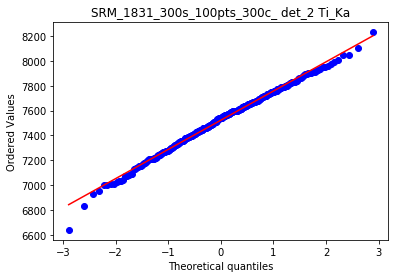

In [15]:
for j in np.arange(len(detector_files)):
    for i in np.arange(line_names.shape[0]):
        plt.clf()
        values = ROI_se_select[j][line_names[i]]
        res = sp.stats.probplot(values, plot = plt)
        plt.title(file_prefix[0]  + ' ' + detector_files[j]  + ' ' + line_names[i])
        plt.savefig( graph_directory + plot_prefix[j] + '_' + detector_files[j] + line_names[i] + '_SE_' + '.png', dpi = 300, transparent = True)

* results for M4 data
* run through all 4 data sets (j loop)
* run through each element (i loop)

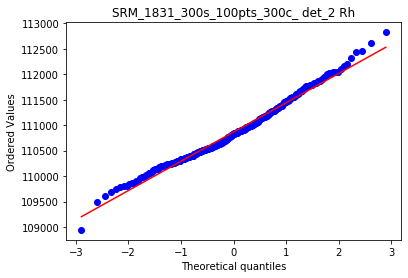

In [16]:
plot_prefix = ['SRM_1831_300s_100pts_300c_',
               'SRM_1831_300s_20x20_300c_', 
              'SRM_1831_300s_100pts_300c_',
              'SRM_1831_300s_20x20_300c_',]
for j in np.arange(len(detector_files)):
    for i in np.arange(len(elements)):
        plt.clf()
        values = ROI_M4_select[j][elements[i]]
        res = sp.stats.probplot(values, plot = plt)
        plt.title(file_prefix[0]  + ' ' + detector_files[j]  + ' ' + elements[i])
        plt.savefig( graph_directory + plot_prefix[j] + '_' + detector_files[j] + elements[i] + '_M4_'  + '.png', dpi = 300, transparent = True)

## Making Statistics dataframes
* we start make new dataframes with statistics on these distributions


* Create a stats dataframe for mean, std, skew, and kurtosis on HyperSpy results

In [249]:
ROI_se_stats = []
for i in np.arange(len(plot_prefix)):
    mean = ROI_se_select[i].mean()
    std = ROI_se_select[i].std()
    skew = ROI_se_select[i].skew()
    kurtosis = ROI_se_select[i].kurtosis()
    df = pd.concat([mean, std, skew, kurtosis], axis = 1)
    df.columns =['mean', 'std', 'skew', 'kurtosis'] 
    df = df.drop(index = 'life time in ms')
    ROI_se_stats.append(df)
ROI_se_stats[0]

,mean,std,skew,kurtosis
Al_Ka,1.067176e+04,133.112321,0.231524,0.025957
Ca_Ka,1.037224e+06,1270.528169,-0.660053,1.282887
Fe_Ka,6.985518e+04,470.001476,0.330399,0.297313
K_Ka,2.705848e+04,254.756397,-0.339476,0.102156
Mg_Ka,7.388458e+03,133.742929,0.076429,-0.533173
Na_Ka,6.793148e+03,145.801972,-0.383628,2.174232
Rh_Ka,7.654768e+04,801.005998,-0.035439,-0.050880
S_Ka,8.253764e+03,134.792599,0.223127,-0.473458
Si_Ka,1.034248e+06,1534.068075,-0.275845,0.041061
Sr_Ka,2.301466e+04,830.734789,0.206743,-0.132467


* create a stats dataframe for mean, std, skew and kurtosis on M4 results

In [250]:
ROI_M4_stats = []
for i in np.arange(len(plot_prefix)):
    mean = ROI_M4_select[i].mean()
    std = ROI_M4_select[i].std()
    skew = ROI_M4_select[i].skew()
    kurtosis = ROI_M4_select[i].kurtosis()
    df = pd.concat([mean, std, skew, kurtosis], axis = 1)
    df.columns =['mean', 'std', 'skew', 'kurtosis']
    df = df.sort_index(axis = 0)
    #df.where(df.index == line_names)
    ROI_M4_stats.append(df)
ROI_M4_stats[1]

,mean,std,skew,kurtosis
Al,1.792512e+04,206.492557,-1.539959,8.334973
Ca,1.521142e+06,2429.208942,-1.128130,4.873520
Fe,9.684660e+04,443.549892,0.442064,0.672280
K,4.073674e+04,234.055954,-0.072843,0.461854
Mg,1.332161e+04,159.163217,-2.070596,17.428358
Na,1.276547e+04,165.314060,-2.425377,19.292213
Rh,1.040951e+05,554.382637,0.437189,0.072776
S,1.202918e+04,260.221780,8.161247,119.953654
Si,1.528875e+06,8018.797253,-10.011713,130.011252
Sr,3.207977e+04,425.543778,0.294235,0.222715


In [251]:
elements = df.index.values
elements

array(['Al', 'Ca', 'Fe', 'K', 'Mg', 'Na', 'Rh', 'S', 'Si', 'Sr', 'Ti'],
      dtype=object)

## PCA calculations on all the data¶

* optional - we can remove any of the stats from the PCA analysis

In [252]:
#columns = ['mean', 'std', 'skew', 'kurtosis']
#columns_used = columns[2:]
#columns_used

In [253]:
#for i in np.arange(len(plot_prefix)):
#    ROI_se_stats[i] = ROI_se_stats[i][columns_used]
#    ROI_M4_stats[i] = ROI_M4_stats[i][columns_used]
    

* we now implement PCA and PLSregression for n_components = 2

In [254]:
#pls2 = PLSRegression(n_components=2)
se_pca = PCA(n_components = 2)
M4_pca = PCA(n_components = 2)

* This generates scalers which are tuned to the repeat measurments:
https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler

In [278]:
se_scaler = skl.preprocessing.StandardScaler(with_mean=False).fit(ROI_se_stats[0])
M4_scaler = skl.preprocessing.StandardScaler(with_mean=False).fit(ROI_M4_stats[0])
se_scaler, M4_scaler

(StandardScaler(copy=True, with_mean=False, with_std=True),
 StandardScaler(copy=True, with_mean=False, with_std=True))

* here we scale all 4 sets using the same scaling applied to repeat/detector 1
* we make two lists of these scaled results

In [279]:
ROI_se_scaled = []
ROI_M4_scaled = []
for i in np.arange(len(plot_prefix)):
    # skl scaling for PCA - se results
    #ROI_se = ROI_se_stats[i]
    #ROI_se = scale(ROI_se_stats[i])
    ROI_se = se_scaler.transform(ROI_se_stats[i])
    ROI_se_scaled.append(ROI_se)
    # skl scaling for PCA - M4 results
    #ROI_M4 = ROI_M4_stats[i]
    #ROI_M4 = scale(ROI_M4_stats[i])
    ROI_M4 = M4_scaler.transform(ROI_M4_stats[i])
    ROI_M4_scaled.append(ROI_M4)

* This step fits the data to a PCA regression with n_components = 2
* The fit also provides the PC loading components
* we are also calculating the variance of the first two PC components

In [282]:
# Make a PCA fit from stationary detector 1 data
# for se data
se_pca = se_pca.fit(ROI_M4_scaled[0])
se_pc1_var = 100 * np.round(se_pca.explained_variance_ratio_[0], decimals=3)
se_pc2_var = 100 * np.round(se_pca.explained_variance_ratio_[1], decimals=3)
# for M4 data
M4_pca = M4_pca.fit(ROI_M4_scaled[0])
M4_pc2_var = 100 * np.round(M4_pca.explained_variance_ratio_[0], decimals=3)
M4_pc2_var = 100 * np.round(M4_pca.explained_variance_ratio_[1], decimals=3)

* this step transforms the data
* This should give a 2d PCA plot to compare between single point and multi point results

In [283]:
se_pca_xforms = []
M4_pca_xforms = []
for i in np.arange(len(plot_prefix)):
    se_pca_xform = se_pca.fit_transform(ROI_se_scaled[i])
    se_pca_xforms.append(se_pca_xform)
    M4_pca_xform = M4_pca.fit_transform(ROI_M4_scaled[i])
    M4_pca_xforms.append(M4_pca_xform)

#X_pca_xform_d2 = pca.fit_transform(map_d2)
#X_pca_xform_d1_map = pca.fit_transform(map_d1_map)

## Plotting PCA results

* Provides a PC loading plot

In [284]:
columns = ROI_M4_stats[0].columns.values
columns

array(['mean', 'std', 'skew', 'kurtosis'], dtype=object)

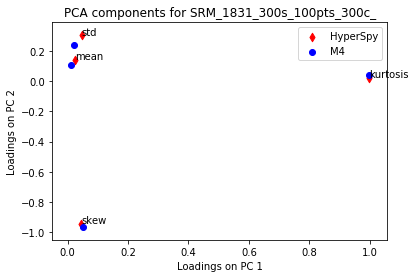

In [327]:
plt.figure()
plt.clf
plt.title('PCA components for ' + file_prefix[0])
plt.xlabel('Loadings on PC 1')
plt.ylabel('Loadings on PC 2')
plt.scatter(se_pca.components_[0], se_pca.components_[1], color = 'r', marker = 'd', label = 'HyperSpy')
plt.scatter(M4_pca.components_[0], M4_pca.components_[1], color = 'b', marker = 'o', label = 'M4')
for i in np.arange(len(columns)):
    plt.text(se_pca.components_[0][i], se_pca.components_[1][i], columns[i])
plt.legend()
plt.savefig(graph_directory + 'PCA_components'  + file_prefix[0] + '.png', dpi=600)

* Provides a transform plot into the PCA 2d space

In [328]:
scan_ranges = ['100pts_D1', 
         '20x20_D1', 
         '100pts_D2',
         '20x20_D2']

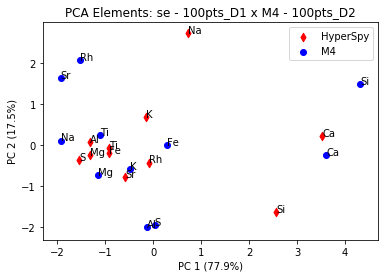

In [332]:
#se to M4 comparisons
item1 = 0
item2 = 2
plt.figure()
plt.clf
#plt.xlim(-5,5)
#plt.ylim(-5,5)
plt.title('PCA Elements: se - ' + scan_ranges[item1] + ' x M4 - ' + scan_ranges[item2])
plt.xlabel('PC 1 (' + str(se_pc1_var) + "%)")
plt.ylabel('PC 2 (' + str(se_pc2_var) + "%)")
plt.scatter(se_pca_xforms[item1][:,0], se_pca_xforms[item1][:,1], color = 'r', marker = 'd', label = 'HyperSpy')
plt.scatter(M4_pca_xforms[item2][:,0], M4_pca_xforms[item2][:,1], color = 'b', marker = 'o', label = 'M4')
for i in np.arange(len(elements)):
    plt.text(se_pca_xforms[item1][i][0], se_pca_xforms[item1][i][1], elements[i])
    plt.text(M4_pca_xforms[item2][i][0], M4_pca_xforms[item2][i][1], elements[i])
plt.legend()
plt.savefig(graph_directory + 'PCA_elements_se-M4_' + scan_ranges[item1] + '_x_' + scan_ranges[item2] +  '.png', dpi=600)

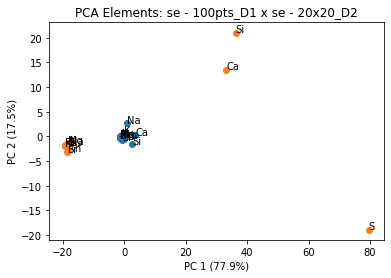

In [337]:
#se to se comparisons
item1 = 0
item2 = 3
plt.figure()
plt.title('PCA Elements: se - ' + scan_ranges[item1] + ' x se - ' + scan_ranges[item2])
#plt.ylim(-1,1)
#plt.xlim(-1,1)
plt.xlabel('PC 1 (' + str(se_pc1_var) + "%)")
plt.ylabel('PC 2 (' + str(se_pc2_var) + "%)")
plt.scatter(se_pca_xforms[item1][:,0], se_pca_xforms[item1][:,1])
plt.scatter(se_pca_xforms[item2][:,0], se_pca_xforms[item2][:,1])
for i in np.arange(len(elements)):
    plt.text(se_pca_xforms[item1][i][0], se_pca_xforms[item1][i][1], elements[i])
    plt.text(se_pca_xforms[item2][i][0], se_pca_xforms[item2][i][1], elements[i])
plt.savefig(graph_directory + 'PCA_elements_se-se_' + scan_ranges[item1] + '_x_' + scan_ranges[item2] +   '.png', dpi=600)

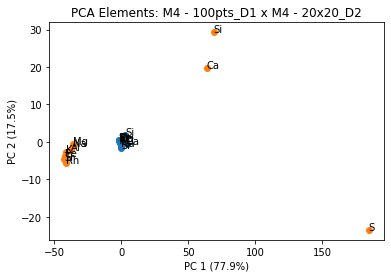

In [342]:
#M4 to M4 comparisons
item1 = 0
item2 = 3
plt.figure()
plt.title('PCA Elements: M4 - ' + scan_ranges[item1] + ' x M4 - ' + scan_ranges[item2])
#plt.ylim(-1,1)
#plt.xlim(-1,1)
plt.xlabel('PC 1 (' + str(se_pc1_var) + "%)")
plt.ylabel('PC 2 (' + str(se_pc2_var) + "%)")
plt.scatter(M4_pca_xforms[item1][:,0], M4_pca_xforms[item1][:,1])
plt.scatter(M4_pca_xforms[item2][:,0], M4_pca_xforms[item2][:,1])
for i in np.arange(len(elements)):
    plt.text(M4_pca_xforms[item1][i][0], M4_pca_xforms[item1][i][1], elements[i])
    plt.text(M4_pca_xforms[item2][i][0], M4_pca_xforms[item2][i][1], elements[i])
plt.savefig(graph_directory + 'PCA_elements_M4-M4_' + scan_ranges[item1] + '_x_' + scan_ranges[item2] +   '.png', dpi=600)

## End of discussion